# Cell Classification using CNN

**Content**:
This notebook demonstrates the use of Convolutional Neural Networks (CNNs) for classifying blood cell images into four categories: EOSINOPHIL, LYMPHOCYTE, MONOCYTE, and NEUTROPHIL.  

1. Imports and Data (has to be run in order to run section 4.)
2. Data preprocessing, model design and training (**Important**: Do not run if you have not downloaded the training dataset)
3. Evaluation of the model (**Important**: Do not run if you have not downloaded the training dataset)
4. Visualisation of sample predictions (Can be run without the 2. and 3. section)

**Dataset**:  
The dataset used in this notebook is available at [Kaggle - Blood Cell Images](https://www.kaggle.com/datasets/paultimothymooney/blood-cells). It contains images of blood cells categorized into four classes.

**Method**:  
We employ Convolutional Neural Networks (CNNs) to classify the blood cell images. 

**Methodology**:
- This notebook has 1 gap in the last section (marked with a `#TODO`) that you have to fill.
- A solution notebook with the filled gap is provided in the GitHub repository.

**Source, Inspiration**:  
This notebook is inspired by [Blood Cell Images Using CNN Model (98.5%)](https://www.kaggle.com/code/mohamedgobara/blood-cell-images-using-cnn-model-98-5/notebook).

## 1. Imports and Data

- `os`: For interacting with the operating system.
- `pandas`: For tabular data manipulation and visualisation.
- `numpy`: For numerical computations.
- `matplotlib.pyplot`: For plotting.
- `skimage.io`: Part of the scikit-image library, used for reading and writing images.
- `keras`: A high-level neural networks API for building and training deep learning models.
- `sklearn`: A library for machine learning, including tools for preprocessing, model selection, and evaluation.
- `tensorflow`: An open-source library for machine learning and deep learning.

In [1]:
# import warnings
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io

import keras
from keras.utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

# warnings.filterwarnings(action="ignore")

We download the pretrained CNN model from the internet (from the online GitHub repository of this workshop) and save them in the current workspace.

In [2]:
import urllib.request
if not os.path.exists('data/CNN_10epochs.keras'):
    os.makedirs('data', exist_ok=True)
    url = "https://github.com/moritzmarquardt/workshop_IBEC/raw/refs/heads/main/data/CNN_10epochs.keras"
    urllib.request.urlretrieve(url, "data/CNN_10epochs.keras")

We also download 8 sample test images to later test our model on.

In [ ]:
test_files = ['data/cnn_test_images/images/TEST/MONOCYTE/_2_3463.jpeg', 
         'data/cnn_test_images/images/TEST/MONOCYTE/_0_8342.jpeg', 
         'data/cnn_test_images/images/TEST/LYMPHOCYTE/_3_2953.jpeg', 
         'data/cnn_test_images/images/TEST/MONOCYTE/_2_1468.jpeg', 
         'data/cnn_test_images/images/TEST/NEUTROPHIL/_7_8662.jpeg', 
         'data/cnn_test_images/images/TEST/EOSINOPHIL/_3_1752.jpeg', 
         'data/cnn_test_images/images/TEST/NEUTROPHIL/_47_8688.jpeg', 
         'data/cnn_test_images/images/TEST/EOSINOPHIL/_0_3083.jpeg']

for f in test_files:
    url = f'https://raw.githubusercontent.com/moritzmarquardt/workshop_IBEC/refs/heads/main/{f}'
    os.makedirs(os.path.dirname(f), exist_ok=True)
    print(url)
    urllib.request.urlretrieve(url, f)

## 2. Data preprocessing, model design and training
**Important**:   
This whole section can only be run if the blood cell dataset is downloaded from [Kaggle - Blood Cell Images](https://www.kaggle.com/datasets/paultimothymooney/blood-cells) and the dataset2-master folder is added as the path data/.dataset2-master.  
If this is not the case (Google colab notebooks) --> **do not run these cells**, just go through the code and the outputs for understanding. The section 4. Visualisation of sample predictions can be run by everyone.

### 2.1 Format Training, Test and Validation data

In this section, the data (if available) is preprocessed.

In [4]:
# Train data
EOSINOPHIL_dir = r'data/.dataset2-master/images/TRAIN/EOSINOPHIL'
LYMPHOCYTE_dir = r'data/.dataset2-master/images/TRAIN/LYMPHOCYTE'
MONOCYTE_dir = r'data/.dataset2-master/images/TRAIN/MONOCYTE'
NEUTROPHIL_dir = r'data/.dataset2-master/images/TRAIN/NEUTROPHIL'

filepaths = []
labels = []
dir_list = [EOSINOPHIL_dir, LYMPHOCYTE_dir, MONOCYTE_dir, NEUTROPHIL_dir]
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir in enumerate(dir_list):
    flist = os.listdir(dir)
    for f in flist:
        fpath = os.path.join(dir, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

bloodCellTrain_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print(bloodCellTrain_df["labels"].value_counts())
bloodCellTrain_df

labels
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64


,filepaths,labels
0,data/.dataset2-master/images/TRAIN/EOSINOPHIL\...,EOSINOPHIL
1,data/.dataset2-master/images/TRAIN/EOSINOPHIL\...,EOSINOPHIL
2,data/.dataset2-master/images/TRAIN/EOSINOPHIL\...,EOSINOPHIL
3,data/.dataset2-master/images/TRAIN/EOSINOPHIL\...,EOSINOPHIL
4,data/.dataset2-master/images/TRAIN/EOSINOPHIL\...,EOSINOPHIL
...,...,...
9952,data/.dataset2-master/images/TRAIN/NEUTROPHIL\...,NEUTROPHIL
9953,data/.dataset2-master/images/TRAIN/NEUTROPHIL\...,NEUTROPHIL
9954,data/.dataset2-master/images/TRAIN/NEUTROPHIL\...,NEUTROPHIL
9955,data/.dataset2-master/images/TRAIN/NEUTROPHIL\...,NEUTROPHIL


In [5]:
# Test data
EOSINOPHIL_dir_test = r'data/.dataset2-master/images/TEST/EOSINOPHIL'
LYMPHOCYTE_dir_test = r'data/.dataset2-master/images/TEST/LYMPHOCYTE'
MONOCYTE_dir_test = r'data/.dataset2-master/images/TEST/MONOCYTE'
NEUTROPHIL_dir_test = r'data/.dataset2-master/images/TEST/NEUTROPHIL'

filepaths_test = []
labels_test = []
dir_list_test = [EOSINOPHIL_dir_test, LYMPHOCYTE_dir_test, MONOCYTE_dir_test, NEUTROPHIL_dir_test]
class_labels_test = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir in enumerate(dir_list_test):
    flist = os.listdir(dir)
    for f in flist:
        fpath = os.path.join(dir, f)
        filepaths_test.append(fpath)
        labels_test.append(class_labels_test[i])

bloodCellTest_df = pd.DataFrame({'filepaths': filepaths_test, 'labels': labels_test})
print(bloodCellTest_df["labels"].value_counts())
bloodCellTest_df

labels
NEUTROPHIL    624
EOSINOPHIL    623
LYMPHOCYTE    620
MONOCYTE      620
Name: count, dtype: int64


,filepaths,labels
0,data/.dataset2-master/images/TEST/EOSINOPHIL\_...,EOSINOPHIL
1,data/.dataset2-master/images/TEST/EOSINOPHIL\_...,EOSINOPHIL
2,data/.dataset2-master/images/TEST/EOSINOPHIL\_...,EOSINOPHIL
3,data/.dataset2-master/images/TEST/EOSINOPHIL\_...,EOSINOPHIL
4,data/.dataset2-master/images/TEST/EOSINOPHIL\_...,EOSINOPHIL
...,...,...
2482,data/.dataset2-master/images/TEST/NEUTROPHIL\_...,NEUTROPHIL
2483,data/.dataset2-master/images/TEST/NEUTROPHIL\_...,NEUTROPHIL
2484,data/.dataset2-master/images/TEST/NEUTROPHIL\_...,NEUTROPHIL
2485,data/.dataset2-master/images/TEST/NEUTROPHIL\_...,NEUTROPHIL


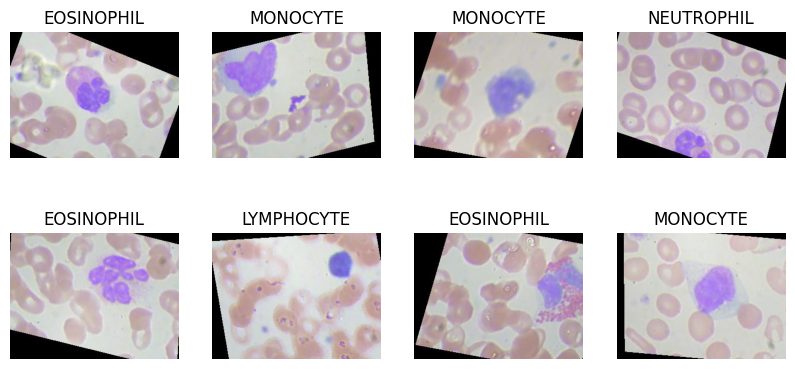

In [6]:
# visualize a few random images of the trainign data df
plt.figure(figsize=(10, 10))
list_random_images = bloodCellTrain_df.sample(n=8, random_state=123)
for i in range(8):
    plt.subplot(4, 4, i + 1)
    random_image_path = list_random_images.iloc[i]['filepaths']
    random_image = skimage.io.imread(random_image_path)
    random_image_label = list_random_images.iloc[i]['labels']
    plt.imshow(random_image)
    plt.title(random_image_label)
    plt.axis('off')
plt.show()

In [7]:
train_test_ratio = bloodCellTest_df.shape[0] / bloodCellTrain_df.shape[0]
print(f"Train Test Ratio (number of test data / number of train data): {train_test_ratio:.2f}")

Train Test Ratio (number of test data / number of train data): 0.25


In [8]:
train_images, val_images = train_test_split(bloodCellTrain_df, test_size=0.25, random_state=42)
# train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)
train_images = bloodCellTrain_df
test_images = bloodCellTest_df

In [9]:
print(test_images.shape)
print(val_images.shape)
print(train_images.shape)

(2487, 2)
(2490, 2)
(9957, 2)


In [10]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_images,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_images,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 9957 validated image filenames belonging to 4 classes.
Found 2487 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


In [11]:
classes=list(train.class_indices.keys())
print (classes)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


### 2.2 Build the model

 Keras, a high-level neural networks API written in Python, is used to build the Convolutional Neural Network (CNN) model. It runs on top of TensorFlow and simplifies the process of designing, training, and deploying deep learning models. In this section, we define the architecture of the CNN model, specifying the layers, activation functions, and other parameters required for training.  

 The design of the CNN is taken from [Blood Cell Images Using CNN Model (98.5%)](https://www.kaggle.com/code/mohamedgobara/blood-cell-images-using-cnn-model-98-5/notebook).

In [12]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

### 2.3 Train the model

In this section, the actual training of the mCNN model is done. The model is trained for 10 epochs using the training data generator (`train`) and validated using the validation data generator (`val`). The training history, including accuracy and loss for both training and validation, is saved for further analysis.

In [13]:
if os.path.exists('data/CNN_10epochs.keras'):
    print('Loading pretrained model from file')
    model = keras.models.load_model('data/CNN_10epochs.keras')
    history = np.load('data/history.npy', allow_pickle=True).item()
else:
    print('Training model')
    history = model.fit(train, epochs=10, validation_data=val, verbose=1)
    model.save('data/CNN_10epochs.keras')
    np.save('data/history.npy', history.history)

Loading pretrained model from file


## 3. Evaluation of the model

First, we evaluate the model with the build in function evaluate() to calculate loss and accuracy on the Test data.

In [14]:
loss, accuracy = model.evaluate(test, verbose=1)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


311/311 ━━━━━━━━━━━━━━━━━━━━ 157s 501ms/step - accuracy: 0.7657 - loss: 0.7562
Test loss: 0.6239777207374573
Test accuracy: 0.7989545464515686


In [15]:
pred_num = model.predict(test)
pred_num = np.argmax(pred_num, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred_num]

311/311 ━━━━━━━━━━━━━━━━━━━━ 158s 507ms/step


### 3.1 Visualise training history and confusion matrix
We can also visualise the training history of the model, including accuracy and loss over epochs, to better understand its performance.

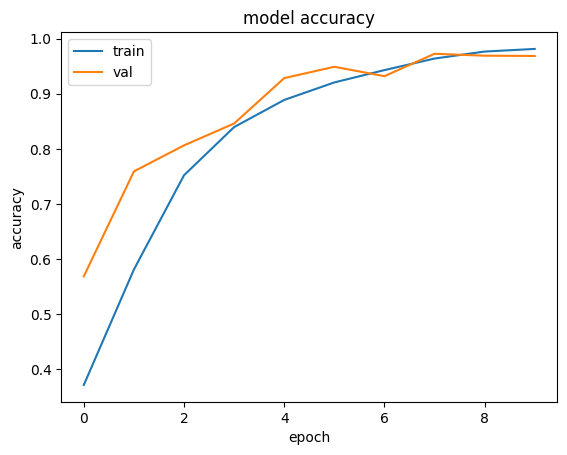

In [16]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

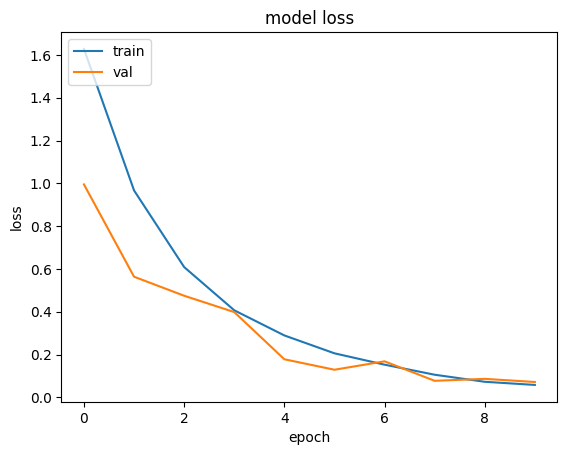

In [17]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred)*100))

              precision    recall  f1-score   support

  EOSINOPHIL       0.74      0.68      0.71       623
  LYMPHOCYTE       0.94      0.97      0.95       620
    MONOCYTE       0.94      0.78      0.85       620
  NEUTROPHIL       0.63      0.76      0.69       624

    accuracy                           0.80      2487
   macro avg       0.81      0.80      0.80      2487
weighted avg       0.81      0.80      0.80      2487

Accuracy of the Model: 79.9%


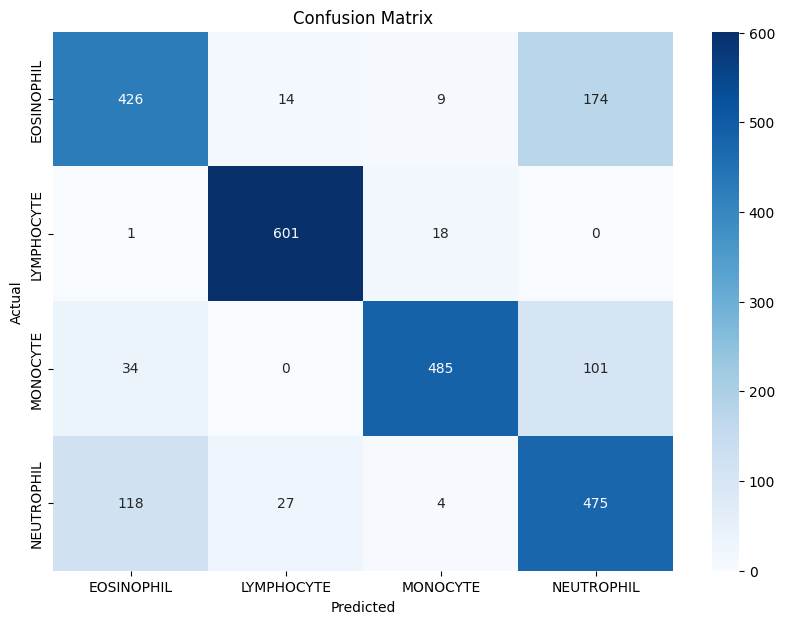

In [19]:
import seaborn as sns

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

## 4. Visualisation of sample predictions
Here we visualise a sample of 8 images from the test data and their predicted labels plus probability.  
**Important**:  
This section can be run after running section 1. (No need to run section 2. and 3. since they can only be run if the training data set has been downloaded)

**TODO**:
1. Use the predict method of the model to predict the classes of the blood cell of 8 test images.

In [20]:
# load pre-trained model for testing and visualization
model = keras.models.load_model('data/CNN_10epochs.keras')

In [ ]:
# load test data
images = []
labels = []
for f in test_files:
    images.append(f)
    labels.append(f.split("/")[-2])

bloodCellTest_df = pd.DataFrame({'filepath': images, 'label': labels})
print(bloodCellTest_df)

image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
test = image_gen.flow_from_dataframe(dataframe=bloodCellTest_df,x_col="filepath", y_col="label",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )

test_dict = test.class_indices
classes = list(test_dict.keys())
images, labels = next(test)  # get a sample batch from the generator

#TODO: predict the class of the images using the model and its method predict
predictions = 

#visualize the images with their predicted and actual labels
plt.figure(figsize=(20, 20))
length = len(labels)
for i in range(length):
    plt.subplot(4, 4, i + 1)
    image = (images[i] + 1) / 2  # scale images between 0 and 1
    plt.imshow(image)
    actual_index = np.argmax(labels[i])
    predicted_index = np.argmax(predictions[i])
    prediction_probability = predictions[i][predicted_index]
    actual_class = classes[actual_index]
    predicted_class = classes[predicted_index]
    title_color = "green" if actual_class == predicted_class else "red"
    plt.title(f"Pred: {predicted_class} with prob. {int(prediction_probability*1000)/10}% \nActual: {actual_class}", color=title_color, fontsize=12)
    plt.axis('off')
plt.show()
